# Ejercicio: análisis semántico de grupos de conversación

<img src="img/news.jpg">

En este ejercicio vamos a realizar el análisis semántico de unos grupos de conversación sobre noticias. Para ello emplearemos técnicas como Latent Dirichlet Allocation que nos permitan detectar temáticas de conversación de forma automática. Comprobaremos también si la detección de estas temáticas puede sernos de utilidad para un problema de clasificación supervisada. ¡Adelante!

## Instrucciones

A lo largo de este cuaderno encontrarás celdas vacías que tendrás que rellenar con tu propio código. Sigue las instrucciones del cuaderno y presta especial atención a los siguientes iconos:

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Deberás responder a la pregunta indicada con el código o contestación que escribas en la celda inferior.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">Esto es una pista u observación que te puede ayudar a resolver la práctica.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">Este es un ejercicio avanzado y voluntario que puedes realizar si quieres profundar más sobre el tema. Te animamos a intentarlo para aprender más ¡Ánimo!</td></tr>
</table>

Para evitar problemas de compatibilidad y de paquetes no instalados, se recomienda ejecutar este notebook bajo uno de los [entornos recomendados de Text Mining](https://github.com/albarji/teaching-environments/tree/master/textmining).

Adicionalmente si necesitas consultar la ayuda de cualquier función python puedes colocar el cursor de escritura sobre el nombre de la misma y pulsar Mayúsculas+Shift para que aparezca un recuadro con sus detalles. Ten en cuenta que esto únicamente funciona en las celdas de código.

¡Adelante!

## Carga de datos

En primer lugar vamos a cargar el corpus con el que trabajaremos. Se trata del corpus **newsgroups20**, de referencia en el campo, y que está fácilmente disponible a través de scikit-learn. Con las siguientes instrucciones cargamos en memoria los datos del conjunto de entrenamiento y test del corpus, así como realizamos una limpieza básica:

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

Los textos vienen etiquetados según el grupo de conversación al que pertenencen. Como podemos ver, existen 20 grupos de conversación, y de ahí el nombre del corpus:

In [2]:
set(newsgroups_train.target)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

El significado de estos grupos de conversación numerados del 0 al 19 es el siguiente. Como vemos, aunque varios de los temas se centran en informática, existen otros grupos variados: automovilismo, deportes, religión, atletismo, ...

In [3]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Contamos además con bastantes textos en el conjunto de entrenamiento:

In [4]:
len(newsgroups_train.data)

11314

Veamos un ejemplo de un texto de un corpus, y el grupo al que está asociado:

In [5]:
print("Texto:\n\n", newsgroups_train.data[0])
print("")
print("Grupo asociado:", newsgroups_train.target_names[newsgroups_train.target[0]])

Texto:

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Grupo asociado: rec.autos


## Análisis de temas con LDA

Ahora vamos a emplear **Latent Dirichlet Allocation** (LDA) para intentar descubrir los temas de conversación existentes. LDA es un método no supervisado, lo que significa que solo requiere de los textos para trabajar, y no necesita de información etiquetada sobre la temática de estos textos. En este corpus concreto ya conocemos de antemano los 20 temas en los que se agrupan los textos, lo cual es un campo de pruebas ideal para ver si LDA es capaz de encontrar a ciegas estos temas, o algunos similares.

### Limpieza de datos

Para obtener un análisis limpio necesitaremos tokenizar los textos, y eliminar símbolos de puntuación y aquellas palabras que no sean relevantes. Todo esto se puede hacer con los vectorizadores de scikit-learn que ya conocemos. En esta ocasión vamos a emplear TF-IDF, que al dar poco peso a palabras habituales del lenguaje es un buen punto de partida para detectar temas de conversación diferenciados. Comenzamos construyendo el vectorizador

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=10)
vectorizer.fit(newsgroups_train.data)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Ahora podemos aplicarlo sobre los datos de entrenamiento:

In [7]:
vects = vectorizer.transform(newsgroups_train.data)

Con esto hemos obtenido una representación vectorizal de los textos, que como es habitual está almacenada en una matriz sparse para ahorrar espacio en memoria:

In [8]:
vects

<11314x10441 sparse matrix of type '<class 'numpy.float64'>'
	with 590492 stored elements in Compressed Sparse Row format>

### Construcción del modelo LDA

La propia librería de aprendizaje automático scikit-learn incluye métodos muy prácticos para aplicar LDA. En particular, LDA está implementado en la clase **LatentDirichletAllocation**. Vamos a crear un transformador de esta clase, indicándole que queremos que trate de encontrar 20 temas en los datos.

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=20)

Los objetos del tipo LatentDirichletAllocation siguen la misma interfaz que otros transformadores de scikit-learn como puede ser TfidfVectorizer. Esto es, disponen de un método **fit** para entrenarlos, y una vez entrenados pueden ser empleados para transformar otros conjuntos de datos.

Como hemos hecho arriba con TfidfVectorizer, vamos a entrenar nuestro modelo LDA. Solo debemos tener en cuenta que LDA no trabaja sobre los textos en bruto, sino que debe recibir una representación vectorial de los mismos. Aprovechando que ya la hemos calculado arriba, hacemos:

In [10]:
lda.fit(vects)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

Una vez entrenado el modelo podemos inspeccionarlo de varias formas. Probablemente el dato más interesante es analizar los componentes del modelo, que se refieren a la pertenencia de cada palabra del corpus a cada tema encontrado:

In [11]:
lda.components_

array([[ 4.78481051,  0.67079597,  0.05      , ...,  0.05      ,
         0.05      ,  0.05      ],
       [ 0.05      ,  0.05      ,  0.05      , ...,  0.05      ,
         0.05      ,  0.05      ],
       [ 0.05      ,  0.05      ,  0.05000147, ...,  0.05      ,
         0.05      ,  0.05      ],
       ...,
       [ 0.05      ,  0.05      ,  0.05      , ...,  0.3400863 ,
         0.05000236,  0.05000001],
       [ 8.64514964, 20.25396504,  0.05000006, ...,  0.05      ,
         0.05      ,  0.05      ],
       [ 0.05      ,  0.05      ,  0.05      , ...,  0.05      ,
         0.05      ,  0.05      ]])

In [12]:
lda.components_.shape

(20, 10441)

¿Cómo interpretar esta matriz? La matriz tiene tantas filas como temas hayamos pedido a LDA que encuentre, y tantas columnas como palabras en el corpus. Esto significa que si cogemos una columna de esta matriz podremos saber cuán relacionada está con cada tema encontrado. Por ejemplo, la siguiente función toma una palabra, busca con qué índice ha sido codificado por TF-IDF, y nos devuelve los pesos para cada tema que ha encontrado LDA para ella:

In [13]:
def findwordrelevances(vectorizer, lda, word):
    if word not in vectorizer.get_feature_names():
        print("La palabra '%s' no existe en el corpus, o se ha descartado por el vectorizador" % word)
        return
    idx = vectorizer.get_feature_names().index(word)
    print("La palabra '%s' tiene la siguiente relevancia por temas:" % word)
    print(lda.components_[:,idx])

In [14]:
findwordrelevances(vectorizer, lda, "windows")

La palabra 'windows' tiene la siguiente relevancia por temas:
[2.93824534e-01 5.00000000e-02 5.00000006e-02 5.00000000e-02
 5.00000001e-02 5.00000002e-02 5.00070271e-02 4.63809081e-01
 5.00000005e-02 5.00969365e-02 5.00000013e-02 8.21821386e+01
 5.00000000e-02 5.00000001e-02 5.00000007e-02 2.29589388e-01
 5.00000000e-02 5.00000000e-02 3.91567610e+00 5.00000005e-02]


In [15]:
findwordrelevances(vectorizer, lda, "god")

La palabra 'god' tiene la siguiente relevancia por temas:
[5.00000000e-02 1.08803782e+00 5.00000003e-02 8.40751842e-02
 5.00000000e-02 5.00000000e-02 5.00000000e-02 5.00000000e-02
 5.00000000e-02 8.07272551e+01 5.00000002e-02 5.00000001e-02
 5.00000000e-02 7.73295700e-02 5.00000001e-02 5.00000001e-02
 3.18956434e-01 5.00000000e-02 1.19253316e+01 5.00000000e-02]


In [16]:
findwordrelevances(vectorizer, lda, "jesus")

La palabra 'jesus' tiene la siguiente relevancia por temas:
[ 0.05        0.05133988  0.05        0.05        0.05        0.05
  0.05        0.05        0.05       42.4407012   0.05        0.05
  0.05        0.05        0.05        0.05        0.05        0.05
  1.03141019  0.05      ]


In [17]:
findwordrelevances(vectorizer, lda, "car")

La palabra 'car' tiene la siguiente relevancia por temas:
[5.00000012e-02 5.00000001e-02 5.00000003e-02 5.00000000e-02
 5.00000000e-02 5.00000001e-02 5.00000034e-02 5.00000051e-02
 5.00000001e-02 6.33493894e+00 5.00000000e-02 5.00035193e-02
 5.00000000e-02 5.17096745e-01 5.00000002e-02 5.00000000e-02
 5.00000000e-02 5.00000002e-02 5.57064546e+01 5.00000210e-02]


<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Prueba a buscar otras palabras que creas que puedan ser muy indicativas de uno de los temas que existen realmente en el corpus. ¿Ves en las relevancia de LDA que esté claramente posicionada a favor de uno de los temas?</td></tr>
</table>

In [18]:
####### INSERT YOUR CODE HERE
findwordrelevances(vectorizer, lda, "baseball")

La palabra 'baseball' tiene la siguiente relevancia por temas:
[ 1.03134418  0.05        0.05        0.05        0.44987042  0.05009388
  0.05        1.15769413  0.05        0.05        0.05        0.05
  4.52692062  0.05       10.08197053  0.05        0.05        0.05
  5.95753405  0.05      ]


<table>
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">Ten en cuenta que LDA es un método estocástico, lo que significa que los temas encontrados pueden variar en cada ejecución. Si observas que las relevancias de palabras por temas que aparecen arriba no tienen sentido, prueba a reejecutar la construcción del modelo LDA.</td></tr>
</table>

También podemos hacer el análisis en otro sentido: ver qué palabras son las más asociadas con cada tema descubierto por LDA. Para ello vamos a basarnos en las siguientes funciones de utilidad:

In [19]:
def print_top_words(vectorizer, lda, n_top_words=20):
    """Dado un vectorizador y en modelo LDA aplicado sobre él, imprime las palabras más relevantes de cada tema"""
    for topic_idx, topic in enumerate(lda.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join(top_words_topic(vectorizer, lda, topic_idx, n_top_words))
        print(message)
    print()
    
def top_words_topic(vectorizer, lda, topic_idx, n_top_words=20):
    """Devuelve una lista de las palabras más representativas para el i-ésimo tema de un modelo LDA"""
    feature_names = vectorizer.get_feature_names()
    topic = lda.components_[topic_idx]
    return [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]

In [20]:
print_top_words(vectorizer, lda)

Topic #0: sale condition shipping offer excellent asking edu intel obo stereo accelerator baud stealth docs adaptec manuals pin 00 jumper 24x
Topic #1: cview mormons ra mormon 8051 cooper salvation lds fundamentalist infallible loves paradise dortmund conclusive transformer lucifer praying condemned punish ranger
Topic #2: patent pitch drinking md ditto taurus cb dtmedin catbyte ingr b30 chase throttle 205 anger fundamentalists concealed truths shaped soldered
Topic #3: tempest cheat mining hillary serdar chop siggraph monthly solved cube der surfaces admits dro mellon carnegie 50mhz davidsson watson jw
Topic #4: loser gainey amd tony nada koufax palm book deluxe graham subscribe hacker sam combo chemistry bio mask palestineans jon sysadmin
Topic #5: msg food helmet ink chinese ama eat douglas garrett suck hank bj flavor adams moa taste andreas restaurant chris leftover
Topic #6: widget motif widgets gl expose functions object paradox borland ___________________________________________

Podemos ayudarnos también de una visualización en forma de **nube de palabras** para entender mejor los temas generados. La siguiente función genera esta visualización.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

def plot_topics(vectorizer, lda):
    """Genera una representación de nubes de palabras para los temas encontrados por LDA"""
    feature_names = vectorizer.get_feature_names()
    ntopics = lda.components_.shape[0]
    nrows = int(np.ceil(np.sqrt(ntopics)))
    ncols = int(np.ceil(ntopics / float(nrows)))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,20))
    plainaxes = axs.ravel()
    for topic_idx, topic in enumerate(lda.components_):
        currentax = plainaxes[topic_idx]
        topidx = topic.argsort()
        plt.sca(currentax)
        wcloud = WordCloud(width=400, height=400, background_color='white')
        wcloud.generate_from_frequencies({feature_names[idx]: topic[idx] for idx in topidx})
        plt.imshow(wcloud, interpolation='bilinear')
        sns.despine()
        currentax.set_title("Topic %d" % topic_idx, fontsize=20)
        currentax.axis('off')
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, wspace=0, hspace=0.1)

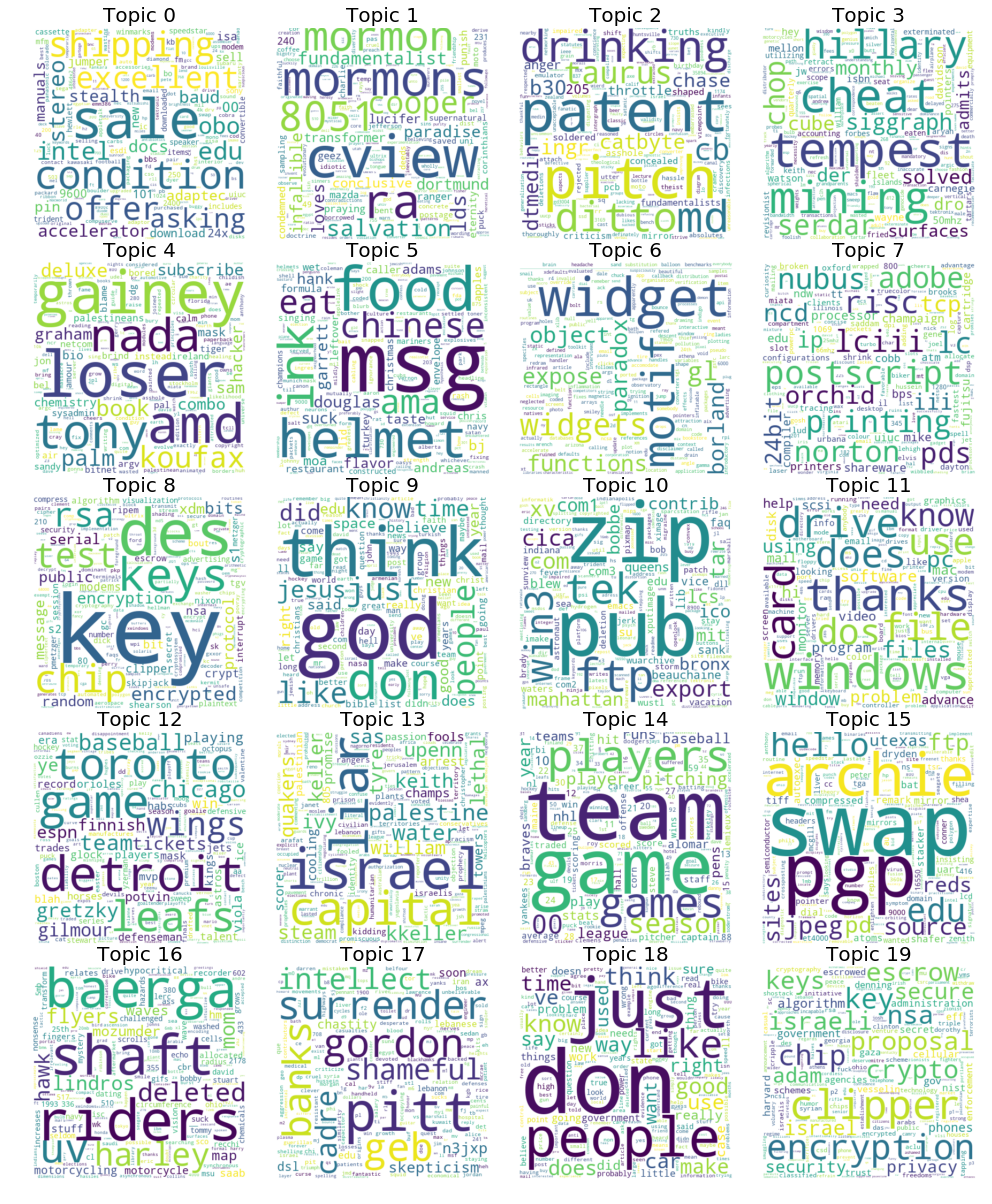

In [22]:
plot_topics(vectorizer, lda)

Finalmente, podemos aplicar el modelo LDA entrenado para obtener la probabilidad de pertenencia a cada tema de un documento vectorizado cualquiera, aplicando la función transform. Por ejemplo, vamos a tomar el siguiente documento de entrenamiento:

In [23]:
docindex = 2
print("Documento original:\n")
print(newsgroups_train.data[docindex])

Documento original:

well folks, my mac plus finally gave up the ghost this weekend after
starting life as a 512k way back in 1985.  sooo, i'm in the market for a
new machine a bit sooner than i intended to be...

i'm looking into picking up a powerbook 160 or maybe 180 and have a bunch
of questions that (hopefully) somebody can answer:

* does anybody know any dirt on when the next round of powerbook
introductions are expected?  i'd heard the 185c was supposed to make an
appearence "this summer" but haven't heard anymore on it - and since i
don't have access to macleak, i was wondering if anybody out there had
more info...

* has anybody heard rumors about price drops to the powerbook line like the
ones the duo's just went through recently?

* what's the impression of the display on the 180?  i could probably swing
a 180 if i got the 80Mb disk rather than the 120, but i don't really have
a feel for how much "better" the display is (yea, it looks great in the
store, but is that all "wo

Ahora le aplicamos la vectorización y el modelo LDA, y así obtenemos las siguientes pertenencias a cada tema:

In [24]:
vectsample = vectorizer.transform([newsgroups_train.data[docindex]])
topics = lda.transform(vectsample)
print("\nProbabilidad de cada tema:\n")
print(topics)


Probabilidad de cada tema:

[[0.00480711 0.00480711 0.00480711 0.00480711 0.00480711 0.00480711
  0.00480711 0.00480711 0.00480711 0.00480718 0.00480711 0.35483895
  0.00480711 0.00480711 0.08901934 0.00480715 0.00480711 0.00480711
  0.47442078 0.00480711]]


¿Tiene sentido esta correspondencia temas? Podemos comprobarlo viendo qué palabras son las más representativas del tema que mayor probabilidad haya obtenido:

In [25]:
print("\nTema más probable: %d\n" % np.argmax(topics))
print("Palabras más relevantes del tema:\n")
print(top_words_topic(vectorizer, lda, np.argmax(topics)))


Tema más probable: 18

Palabras más relevantes del tema:

['don', 'just', 'people', 'like', 'think', 'know', 'good', 'time', 'use', 'does', 'car', 've', 'make', 'way', 'say', 'right', 'used', 'want', 'really', 'did']


Este proceso puede realizarse con cualquier texto, no solo con los textos que se han usado durante el entrenamiento. Por ejemplo:

In [26]:
sampletext = """
We know that all mankind are fallen, we all bear the stain of Adams sin.
But Jesus came to redeem a people for Himself with His blood. Ephesians 1:7

Believers in Jesus, those who have accepted His Salvation, are now people from every tribe, race, nation and language. Revelation 5:9-10 But God originally chose a people group to be the ones who would be His Witnesses and to display His Light to the world. Those people failed in their task and were ejected for the holy Land in two dispersions.
Those of the second diaspora; the Jewish people have come back to a part of the holy Land, but still in unbelief and apostasy.

The Bible tells us in many prophesies; that all of Israel, who are by now an uncountable multitude, will return to the holy Land and will fulfil at last, God's plan for them.
The New Testament tells about a symbolic Olive Tree, one that has had all its branches removed. That Tree is Jesus and all who believe in Him, will be grafted into that Tree.
So whether we Christians are actual descendants of Jacob or not, the people who will fulfil God's Plan for a righteous people in His Land; will all be Christians. 
"""

vectsample = vectorizer.transform([sampletext])
topics = lda.transform(vectsample)
print("\nProbabilidad de cada tema:\n")
print(topics)
print("\nTema más probable: %d\n" % np.argmax(topics))
print("Palabras más relevantes del tema:\n")
print(top_words_topic(vectorizer, lda, np.argmax(topics)))


Probabilidad de cada tema:

[[0.00697018 0.05711487 0.0261367  0.00697018 0.00697019 0.00697018
  0.00697018 0.00697018 0.00697018 0.69629718 0.00697018 0.00697018
  0.00697018 0.00697018 0.02558262 0.00697018 0.00697018 0.00697018
  0.09031596 0.00697018]]

Tema más probable: 9

Palabras más relevantes del tema:

['god', 'think', 'don', 'just', 'people', 'like', 'know', 'jesus', 'did', 'time', 'believe', 'space', 'new', 'good', 'year', 'said', 'does', 'edu', 'say', 'right']


<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">¿Tiene sentido el tema que se ha asignado al texto?
</table>

## LDA para problemas supervisados

Latent Dirichlet Analysis también puede emplearse para generar variables explicativas de utilidad (los topics) que puedan usarse para reforzar un sistema de clasificación supervisada. Vamos a ver a continuación cómo hacer esto.

En primer lugar vamos a construir un sistema de clasificación básico basado en TF-IDF y una SVM lineal, siguiendo el estilo de ejercicios anteriores:

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LinearSVC())
    ]
)

model.fit(newsgroups_train.data, newsgroups_train.target)
acc = model.score(newsgroups_test.data, newsgroups_test.target)
print("Accuracy on test data", acc)

Accuracy on test data 0.6919808815719597


Ahora vamos a mejorar este Pipeline de clasificación añadiendo variables de LDA. Lo que haremos será exponer al clasificador (LinearSVC) dos grupos de variables explicativas o _features_:

* La vectorización generada por TF-IDF
* Las probabilidades de pertentencia a cada tema detectador por LDA. Nótese que para calcular LDA necesitamos previamente haber hecho la vectorización TF-IDF.

En situaciones como esta en la que queremos proporcionar dos o más conjuntos de variables explicativas al clasificador lo que hacemos es definir un Pipeline que calcule cada conjunto de variables por separado. Empezaremos por el Pipeline de TF-IDF:

In [28]:
pipeline_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer())
])

Ahora definimos otro Pipeline que incluya LDA, para lo cual es pre-requisito haber realizado también TF-IDF. Por tanto el Pipeline se compone de estos dos pasos:

In [29]:
pipeline_lda = Pipeline([
    ('vectorizer', TfidfVectorizer()), 
    ('lda', LatentDirichletAllocation(n_components=20))
])

Una vez tenemos los Pipelines listos podemos combinarlos usando **FeatureUnion**. Un objeto FeatureUnion recibe una lista de parejas, cada parejas siendo el nombre de ese grupo de features y el Pipeline que lo construye. Un FeatureUnion puede a su vez meterse dentro de un Pipeline de modelado, al que luego puede seguir un clasificador. Por tanto para terminar de definir nuestro modelo escribimos lo siguiente:

In [30]:
from sklearn.pipeline import FeatureUnion

model = Pipeline([
    ('merger', FeatureUnion([
        ('tfidf_pipeline', pipeline_tfidf),
        ('topics_pipeline', pipeline_lda),
    ])),
    ('classifier', LinearSVC())   
])

Ahora entrenamos este modelo y medimos el acierto:

In [31]:
model.fit(newsgroups_train.data, newsgroups_train.target)
acc = model.score(newsgroups_test.data, newsgroups_test.target)
print("Accuracy on test data", acc)

Accuracy on test data 0.693441317047265


<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">¿Ha mejorado el nivel de acierto tras incluir las variables explicativas basadas en LDA?
</table>

# Otros modelos de detección de topics

Como alternativa a LDA existen otros modelos que también toman como entrada una representación vectorial de un corpus y tratan de inferir los temas subyacentes a ese corpus. En scikit-learn disponemos de los siguientes:

* Latent Semantic Analysis (LSA): implementado en la clase [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD).
* Non-negative Matrix Factorization (NMF): implementado en la clase [NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF).

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Repite el análisis de descomposición de temas anterior con LSA, construyendo un modelo LSA y generando la gráfica de nube de palabras. ¿Observas diferencias con la descomposición en temas obtenida por LDA?
</table>

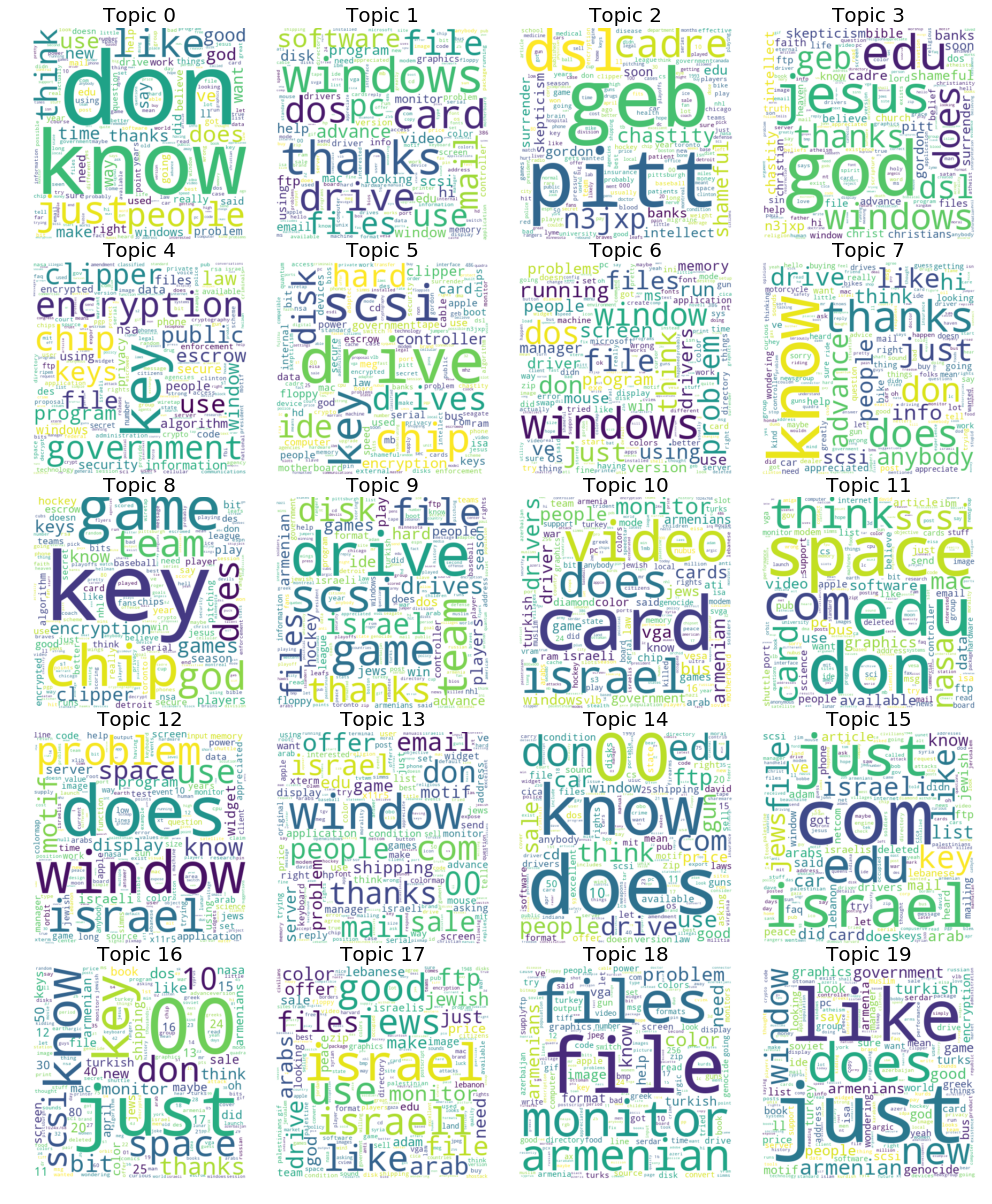

In [32]:
####### INSERT YOUR CODE HERE
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=20)
lsa.fit(vects)
plot_topics(vectorizer, lsa)

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Repite el análisis de nuevo con NMF. ¿Qué diferencias observas ahora?
</table>

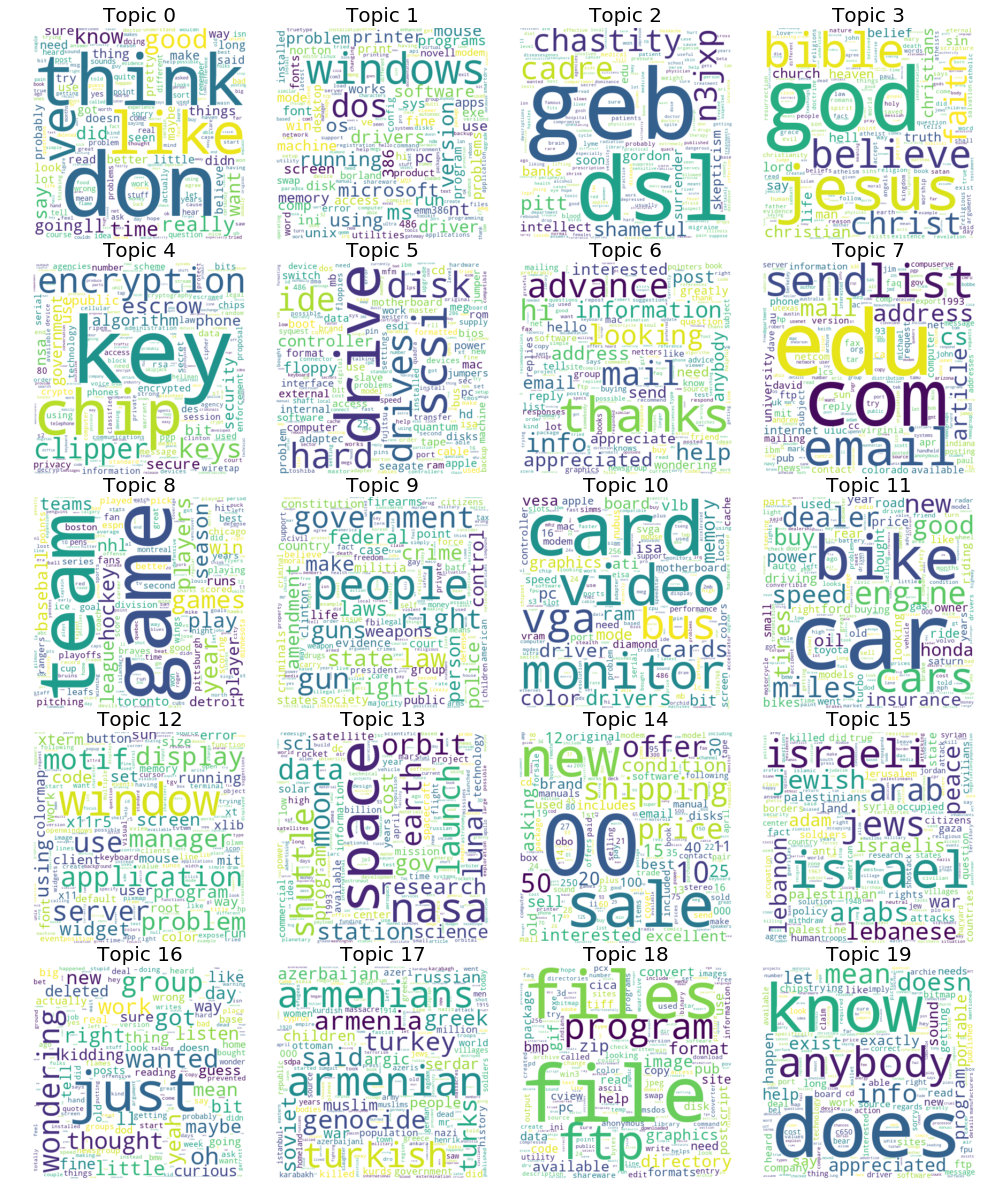

In [33]:
####### INSERT YOUR CODE HERE
from sklearn.decomposition import NMF

nmf = NMF(n_components=20)
nmf.fit(vects)
plot_topics(vectorizer, nmf)

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Ahora repite el modelo de clasificación supervisada con LDA que utilizamos arriba, pero empleando un modelo LSA en su lugar. ¿Obtienes mejor precisión en test?
</table>

In [34]:
####### INSERT YOUR CODE HERE
pipeline_lsa = Pipeline([
    ('vectorizer', TfidfVectorizer()), 
    ('lda', TruncatedSVD(n_components=20))
])

model = Pipeline([
    ('merger', FeatureUnion([
        ('tfidf_pipeline', pipeline_tfidf),
        ('topics_pipeline', pipeline_lsa),
    ])),
    ('classifier', LinearSVC())   
])

model.fit(newsgroups_train.data, newsgroups_train.target)
acc = model.score(newsgroups_test.data, newsgroups_test.target)
print("Accuracy on test data", acc)

Accuracy on test data 0.692113648433351


<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Repite de nuevo con NMF, ¿qué resultado en test obtienes ahora?
</table>

In [35]:
####### INSERT YOUR CODE HERE
pipeline_nmf = Pipeline([
    ('vectorizer', TfidfVectorizer()), 
    ('nmf', NMF(n_components=20))
])

model = Pipeline([
    ('merger', FeatureUnion([
        ('tfidf_pipeline', pipeline_tfidf),
        ('topics_pipeline', pipeline_nmf),
    ])),
    ('classifier', LinearSVC())   
])

model.fit(newsgroups_train.data, newsgroups_train.target)
acc = model.score(newsgroups_test.data, newsgroups_test.target)
print("Accuracy on test data", acc)

Accuracy on test data 0.692113648433351
